In [1]:
# Math, Optimization and Stats. Packages
import numpy as np                           
import torch as torch  
from scipy.optimize import minimize
import emcee
import time      
#from pyscenarios.sobol import sobol  
from scipy import constants, interpolate
%matplotlib inline
import itertools
import math

# Plotting packages and settings
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib import rc
from matplotlib.pyplot import figure
#import daft
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
# from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
#                                                   mark_inset)

# Data Management
import pandas as pd
from pickle import dump, load  

# Paralellization Packages and settings
import dask
from multiprocessing import Pool
import multiprocessing as mp
import os
mp.set_start_method('fork')
os.environ["OMP_NUM_THREADS"] = "1" 
from dask.distributed import Client, progress
from dask import config as cfg
# The specific start method and OMP threads is chosen to make
# emcee run in parallel. May change based on the machine. Read
# their documentation for more information.

#import freud
import gsd.hoomd
import hoomd
from utility.rdf_analysis import rdf2sq

In [2]:
def snap_molecule_indices(snap):
    """Find molecule index for each particle.

    Given a snapshot from a trajectory, compute clusters of bonded molecules
    and return an array of the molecule index of each particle.

    Parameters
    ----------
    snap : gsd.hoomd.Snapshot
        Trajectory snapshot.

    Returns
    -------
    numpy array (N_particles,)

    """
    system = freud.AABBQuery.from_system(snap)
    num_query_points = num_points = snap.particles.N
    query_point_indices = snap.bonds.group[:, 0]
    point_indices = snap.bonds.group[:, 1]
    distances = system.box.compute_distances(
        system.points[query_point_indices], system.points[point_indices]
    )
    nlist = freud.NeighborList.from_arrays(
        num_query_points, num_points, query_point_indices, point_indices, distances
    )
    cluster = freud.cluster.Cluster()
    cluster.compute(system=system, neighbors=nlist)
    return cluster.cluster_idx


def intermolecular_rdf( gsdfile, A_name, B_name, start=0, stop=None, r_max=None, r_min=0, bins=1000, exclude_bonded=True):
    """Compute intermolecular RDF from a GSD file.

    This function calculates the radial distribution function given a GSD file
    and the names of the particle types. By default it will calculate the RDF
    for the entire trajectory.

    It is assumed that the bonding, number of particles, and simulation box do
    not change during the simulation. (Note: Exclude Bonded Feature most likley broken with hoomd 4.1.0 - Hopefner Group)

    Parameters
    ----------
    gsdfile : str
        Filename of the GSD trajectory.
    A_name, B_name : str
        Name(s) of particles between which to calculate the RDF (found in
        gsd.hoomd.Snapshot.particles.types)
    start : int
        Starting frame index for accumulating the RDF. Negative numbers index
        from the end. (Default value = 0)
    stop : int
        Final frame index for accumulating the RDF. If None, the last frame
        will be used. (Default value = None)
    r_max : float
        Maximum radius of RDF. If None, half of the maximum box size is used.
        (Default value = None)
    r_min : float
        Minimum radius of RDF. (Default value = 0)
    bins : int
        Number of bins to use when calculating the RDF. (Default value = 100)
    exclude_bonded : bool
        Whether to remove particles in same molecule from the neighbor list.
        (Default value = True)

    Returns
    -------
    freud.density.RDF
    """
    with gsd.hoomd.open(name = gsdfile, mode = 'r') as trajectory:
        snap = trajectory[0]

        if r_max is None:
            # Use a value just less than half the maximum box length.
            r_max = np.nextafter(
                np.max(snap.configuration.box[:3]) * 0.5, 0, dtype=np.float32
            )

        rdf = freud.density.RDF(bins=bins, r_max=r_max, r_min=r_min)

        type_A = snap.particles.typeid == snap.particles.types.index(A_name)
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)

        if exclude_bonded:
            molecules = snap_molecule_indices(snap)
            molecules_A = molecules[type_A]
            molecules_B = molecules[type_B]

        for snap in trajectory[start:stop]:

            A_pos = snap.particles.position[type_A]
            if A_name == B_name:
                B_pos = A_pos
                exclude_ii = True
            else:
                B_pos = snap.particles.position[type_B]
                exclude_ii = False

            box = snap.configuration.box
            system = (box, A_pos)
            aq = freud.locality.AABBQuery.from_system(system)
            nlist = aq.query(
                B_pos, {"r_max": r_max, "exclude_ii": exclude_ii}
            ).toNeighborList()

            if exclude_bonded:
                pre_filter = len(nlist)
                indices_A = molecules_A[nlist.point_indices]
                indices_B = molecules_B[nlist.query_point_indices]
                nlist.filter(indices_A != indices_B)
                post_filter = len(nlist)

            rdf.compute(aq, neighbors=nlist, reset=False)
        normalization = post_filter / pre_filter if exclude_bonded else 1
        return rdf, normalization
    
def run_simulation(i,xs_filename):
    
    # Reload Samples
    input_dict = load(open(xs_filename, 'rb'))
    xs = input_dict['xs']
    nsamps = len(xs[:,0])
    ndims  = len(xs[0,:])
    
    #Thermodynamic state variables
    k   = 3.29982916e-27 #boltzmann constant,   [kcal/K/particle]   
    av  = 6.0223e23      #avagadro number,      [particle/mol]  
    T   = 42.2           #temperature,          [K]
    kbT = k * av * T     #thermal energy,       [kcal/mol]
    ρ   = 0.02477        #experimental density, [particle/Å^3]   
    
    t1 = time.time()
    
    # Defines the parameters of the box
    m = 6
    N_particles = 4 * m**3
    spacing = 6
    K = math.ceil(N_particles**(1 / 3))
    L = K * spacing * xs[i%nsamps][1] # \sigma
    x = np.linspace(-L / 2, L / 2, K, endpoint=False)
    position = list(itertools.product(x, repeat=3))

    # Use the parameters to feed into a Hoomd frame
    frame = gsd.hoomd.Frame()
    frame.particles.N = N_particles
    frame.particles.position = position[0:N_particles]
    frame.particles.typeid = [0] * N_particles
    frame.configuration.box = [L, L, L, 0, 0, 0]
    frame.particles.types = ['A']
    with gsd.hoomd.open(name='lattice_folder/lattice_' + str(i) +'.gsd', mode='w') as f:
        f.append(frame)

    # Simulation settings, Integrator, Force Field, Simulation Object, etc. 
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(device=cpu, seed=1)
    sim.create_state_from_gsd(filename='lattice_folder/lattice_' + str(i) +'.gsd')
    dt = 0.005
    integrator = hoomd.md.Integrator(dt=dt)
    cell = hoomd.md.nlist.Cell(buffer=0.4)

    # Force Field Inputs
    mie = hoomd.md.pair.Mie(nlist=cell)
    mie.params[('A', 'A')] = dict(epsilon=xs[i%nsamps][2], sigma=xs[i%nsamps][1], n=xs[i%nsamps][0], m=6)
    mie.r_cut[('A', 'A')] = 3*xs[i%nsamps][1]
    integrator.forces.append(mie)

    # Thermostat settings
    mttk = hoomd.md.methods.thermostats.MTTK(kT=kbT, tau=100*dt) # Nose-Hoover
    nvt = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(),
    thermostat=mttk)
    integrator.methods.append(nvt)
    sim.operations.integrator = integrator
    
    # Thermalization
    sim.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=kbT)
    sim.run(5_000)
    
    # Resizing box to hit target density
    ramp = hoomd.variant.Ramp(A=0, B=1, t_start=sim.timestep, t_ramp=10_000)
    rho = sim.state.N_particles / sim.state.box.volume
    initial_box = sim.state.box
    final_box = hoomd.Box.from_box(initial_box)  # make a copy of initial_box
    final_rho = ρ
    final_box.volume = sim.state.N_particles / final_rho
    box_resize_trigger = hoomd.trigger.Periodic(10)
    box_resize = hoomd.update.BoxResize(box1=initial_box, box2=final_box, variant=ramp, trigger=box_resize_trigger)
    sim.operations.updaters.append(box_resize)
    sim.run(10_000)
    
    
    # Equilibrating with finalized simulation settings
    sim.operations.updaters.remove(box_resize)
    sim.run(50_000)

    # Add data collection to simulation, Thermodynamic Properties and RDF
    gsd_writer = hoomd.write.GSD(filename='sim_trajectories/mie_' + str(i) + '.gsd',
                              trigger=hoomd.trigger.Periodic(1000),
                              mode='wb')
    sim.operations.writers.append(gsd_writer)
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    logger = hoomd.logging.Logger()
    logger.add(thermodynamic_properties)
    gsd_writer.log = logger
    
    # Run Simulation
    sim.run(5e5)

    #IMPORTANT, YOU MUST FLUSH IN ORDER FOR THE GSD WRITER TO PUT DATA IN THE FILE
    gsd_writer.flush()
    
    # Save Collected data. 
    rdf, normalization = intermolecular_rdf('sim_trajectories/mie_' + str(i) + '.gsd', 'A', 'A', r_max=0.95*((N_particles/ρ)**(1/3))/2, exclude_bonded=False)
    
    t2 = time.time()
    
    returnDict = dict()
    returnDict['model_rdf'] = rdf.rdf
    returnDict['t'] = t2-t1
    returnDict['r'] = rdf.bin_centers
    
    return returnDict

In [3]:
def se_kernel(x1, x2, l, width):
    """
    Computes the squared exponential kernel between the tensors x and y with hyper-parameters l and width.
    N corresponds to the number of samples and D corresponds to the number of dimensions of the input function.
    
    Parameters
    ----------
    
    x: Tensor [N,D]
        Feature vector for N samples with D dimensions each
    
    y: Tensor [N,D]
        Feature vector for N samples with D dimensions each
        
    l: Tensor [D]
        Lengthscale hyper parameter
        
    width: Float
        Width hyper parameter
    """
    K = width**2 * torch.exp(-(torch.cdist(x1/l,x2/l,p=2)**2)/2)
    return K

def subset_surrogate(Xi, Xd, l, width, y, KddInv):
    """
    Computes the subset gaussian process estimate of the structure factor given a set of pair potential parameters. 
    
    Parameters
    ----------
    
    Xi: Tensor [M,D]
        Feature vector for M samples with D dimensions each. This corresponds to the points you wish to infer.
    
    Xd: Tensor [M,D]
        Feature vector for N samples with D dimensions each. This corresponds to the points you trained on.
        
    l: Tensor [D]
        Lengthscale hyper parameter.
        
    width: Float
        Width hyper parameter
        
    KddInv: Tensor [N,N]
        This is the inverted kernel matrix of the training set Xd
        
    Returns
    -------
    
    μ: Tensor [η,N]
        The mean estimate for each S(q) at each potential. The S(q)'s are organized in vertical lines where the column
        dimension indexes the potential parameters. 
        
    """
    Kid = se_kernel(Xi, Xd, l, width)
    KidKddInv = (Kid @ KddInv)
    return 1 + (KidKddInv @ (y - 1)).T

In [4]:
experimentalCSVFilename = 'exp_data/ne_42K_rdf_new.csv'

data = pd.read_csv(experimentalCSVFilename)
r_exp_raw = np.array(data['r'])
rdf_exp_raw = np.array(data[' g'])

rmin = r_exp_raw[0]
rmax = 15.512161254882812
Δr = 0.2099
rnum = int((rmax - rmin)/Δr)

# Interpolalate the experimental data to make it consistent with the simulations
r  = torch.tensor(np.linspace(rmin, rmax, num=rnum))
rdf_exp_i = interpolate.splrep(r_exp_raw, rdf_exp_raw, s=0)
rdf_exp = torch.from_numpy(interpolate.splev(r, rdf_exp_i, der=0))

rdf_exp = rdf_exp-min(rdf_exp)

# print("Old length: ", len(r_exp_raw))
# print("New length: ", len(r))

# figure(figsize = (12,10),dpi=80)
# plt.title("Experimental Radial Distribution Function for Neon")
# plt.scatter(r_exp_raw,rdf_exp_raw,alpha=0.4)
# plt.plot(r_exp_raw,rdf_exp_raw)
# #plt.plot(r, rdf_exp)
# plt.xlim(rmin,rmax)
# plt.xlabel("$\AA$")
# plt.show()

In [5]:
# Import the training data generated by 1_sample_gen.ipynb

input_dict = load(open('training_data/samples.p', 'rb'))
xd = input_dict['xs']

input_dict = load(open('training_data/training_rdf.p', 'rb'))
r_raw = input_dict['r']
model_rdf_raw = input_dict['model_rdf']

model_rdf = torch.zeros(len(model_rdf_raw),rnum)
r = np.linspace(rmin,rmax,rnum)

print("Old length: ", len(r_raw))
print("New length: ", len(r))

# We can interpolate this data to have the same .
for i in range(len(model_rdf_raw)):
    rdf_i = interpolate.splrep(r_raw, model_rdf_raw[i], s=0)
    model_rdf[i] = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))  
    
model_rdf_μ = torch.sum(model_rdf,dim=0)/len(model_rdf)    
    
# figure(figsize = (12,10),dpi=80)
# plt.title("GP Training Set")
# for i in range(len(model_rdf_raw)):
#     plt.plot(r,model_rdf[i],alpha=0.4)
# plt.xlim(rmin,rmax)
# plt.xlabel("$\AA$")
# plt.show()

Old length:  1000
New length:  73


In [6]:
print("Attempting to Load Chain...")
    
input_dict = load(open('MCMCSamplesRDF.p', 'rb'))
chain = input_dict['chain']
autocorr = input_dict['autocorr']

loadedChain = True

print("Success!")

Attempting to Load Chain...
Success!


In [7]:
# Try to load previously computed simulation data 
try: 
    input_dict = load(open('testing_data/xs_MAPTest2.p', 'rb'))
    xs_MAPTest = input_dict['xs']
    
except:
    MAP = np.mean(np.mean(chain,axis=0),axis=0)
    STD = np.std(np.reshape(chain,(160*5_000,4)),axis=0)
    
    Σ_map = np.diag(STD[:3])**2
    μ_map = MAP[:3]
    
    xs_MAPTest = abs(np.random.multivariate_normal(μ_map,Σ_map,160))
    
    # Save the input samples
    output_dict = dict(xs = xs_MAPTest)
    dump(output_dict, open('testing_data/xs_MAPTest2.p', 'wb'))

In [8]:
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# axs[0].scatter(xs_MAPTest[:,0],xs_MAPTest[:,1])
# axs[0].set_title("N vs Sigma")
# axs[1].scatter(xs_MAPTest[:,0],xs_MAPTest[:,2])
# axs[1].set_title("N vs Epsilon")
# axs[2].scatter(xs_MAPTest[:,2],xs_MAPTest[:,1])
# axs[2].set_title("Epsilon vs Sigma")
# plt.show()

In [9]:
# Try to load previously computed simulation data 
try: 
    input_dict = load(open('testing_data/testing_MAP_rdf2.p', 'rb'))
    totalResults = input_dict['totalResults']
    totalTime = input_dict['totalTime']

# If not run them
except:

    cfg.set({'distributed.scheduler.worker-ttl': None}) # This stops dask from crying when the sims take a long time.
    client = Client(threads_per_worker=1, n_workers=40)
    
    xs_filename = 'testing_data/xs_MAPTest2.p'

    # Queue up function calls into dask
    lazy_results = []
    for i in range (530,530+160,1):
        lazy_results.append(dask.delayed(run_simulation)(i,xs_filename))

    t1 = time.time()
    # Split the dask calls to run 4 sets of 40 sims
    totalResults = []
    i = 0
    while i < 160:
        # Allow dask to parallelize the set of simulations and run them
        results = dask.compute(*lazy_results[i:(i+40)])
        totalResults.append(results)
        i += 40        

    t2 = time.time()
    totalTime = (t2-t1)
    
    output_dict = dict(totalResults = totalResults, totalTime = (t2 - t1))
    dump(output_dict, open('testing_data/testing_MAP_rdf2.p', 'wb'))

In [10]:
results = []
for result_i in totalResults:
    for outDict in result_i:
        results.append(outDict)

tensorResults = torch.zeros(160,73)
for i in range(160):
    rdf_i = interpolate.splrep(results[i]['r'], results[i]['model_rdf'], s=0)
    sim = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))
    tensorResults[i] =  torch.tensor(sim)

/scratch/local/u1262705/8542453/ipykernel_2406225/817206292.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensorResults[i] =  torch.tensor(sim)


In [11]:
tensorResultsRolled = torch.roll(tensorResults,50,dims=0)

In [12]:
# Import the training data generated by 1_sample_gen.ipynb

input_dict = load(open('training_data/samples.p', 'rb'))
xd = input_dict['xs']

input_dict = load(open('training_data/training_rdf.p', 'rb'))
r_raw = input_dict['r']
model_rdf_raw = input_dict['model_rdf']

model_rdf = torch.zeros(len(model_rdf_raw),rnum)
r = np.linspace(rmin,rmax,rnum)

print("Old length: ", len(r_raw))
print("New length: ", len(r))

# We can interpolate this data to have the same .
for i in range(len(model_rdf_raw)):
    rdf_i = interpolate.splrep(r_raw, model_rdf_raw[i], s=0)
    model_rdf[i] = torch.from_numpy(interpolate.splev(r, rdf_i, der=0))  

Old length:  1000
New length:  73


In [13]:
# Define training set data|
Xd = torch.tensor(xd).float()
y = model_rdf.float()

# Choose hyper parameters
arr = [3.1590, 0.1303, 0.2398, 0.0511, 0.0053]
arr = [3.9268e+00, 2.4224e-01, 9.0420e-02, 5.0339e-02, 4.8384e-04]
l = torch.tensor([arr[0],arr[1],arr[2]]).float()
w = torch.tensor(arr[3]).float()
σn = torch.tensor(arr[4]).float()

# Compute subset GP prediction over prior predictive set
Kdd = se_kernel(Xd,Xd,l,w) + torch.eye(len(Xd))*σn
KddInv = torch.linalg.inv(Kdd)

In [14]:
Xi = torch.tensor(xs_MAPTest).float()
GPOut = subset_surrogate(Xi, Xd, l, w, y, KddInv)

In [15]:
from matplotlib import cm
err = torch.zeros(160)
for i in range(160):
    err[i] = torch.sqrt(torch.sum((GPOut.T[i] - tensorResultsRolled[i])**2)/73)

### Error of test set as a function of r

In [16]:
RMSE = torch.sqrt(torch.mean((GPOut.T - tensorResultsRolled)**2,dim=0))
RMSE_total = torch.sqrt(torch.mean((GPOut.T - tensorResultsRolled)**2))

print(np.sqrt(torch.sum(RMSE**2/73)))
print(np.sqrt(torch.sum(err**2/160)))
print(RMSE_total)

tensor(0.0280)
tensor(0.0280)
tensor(0.0280)


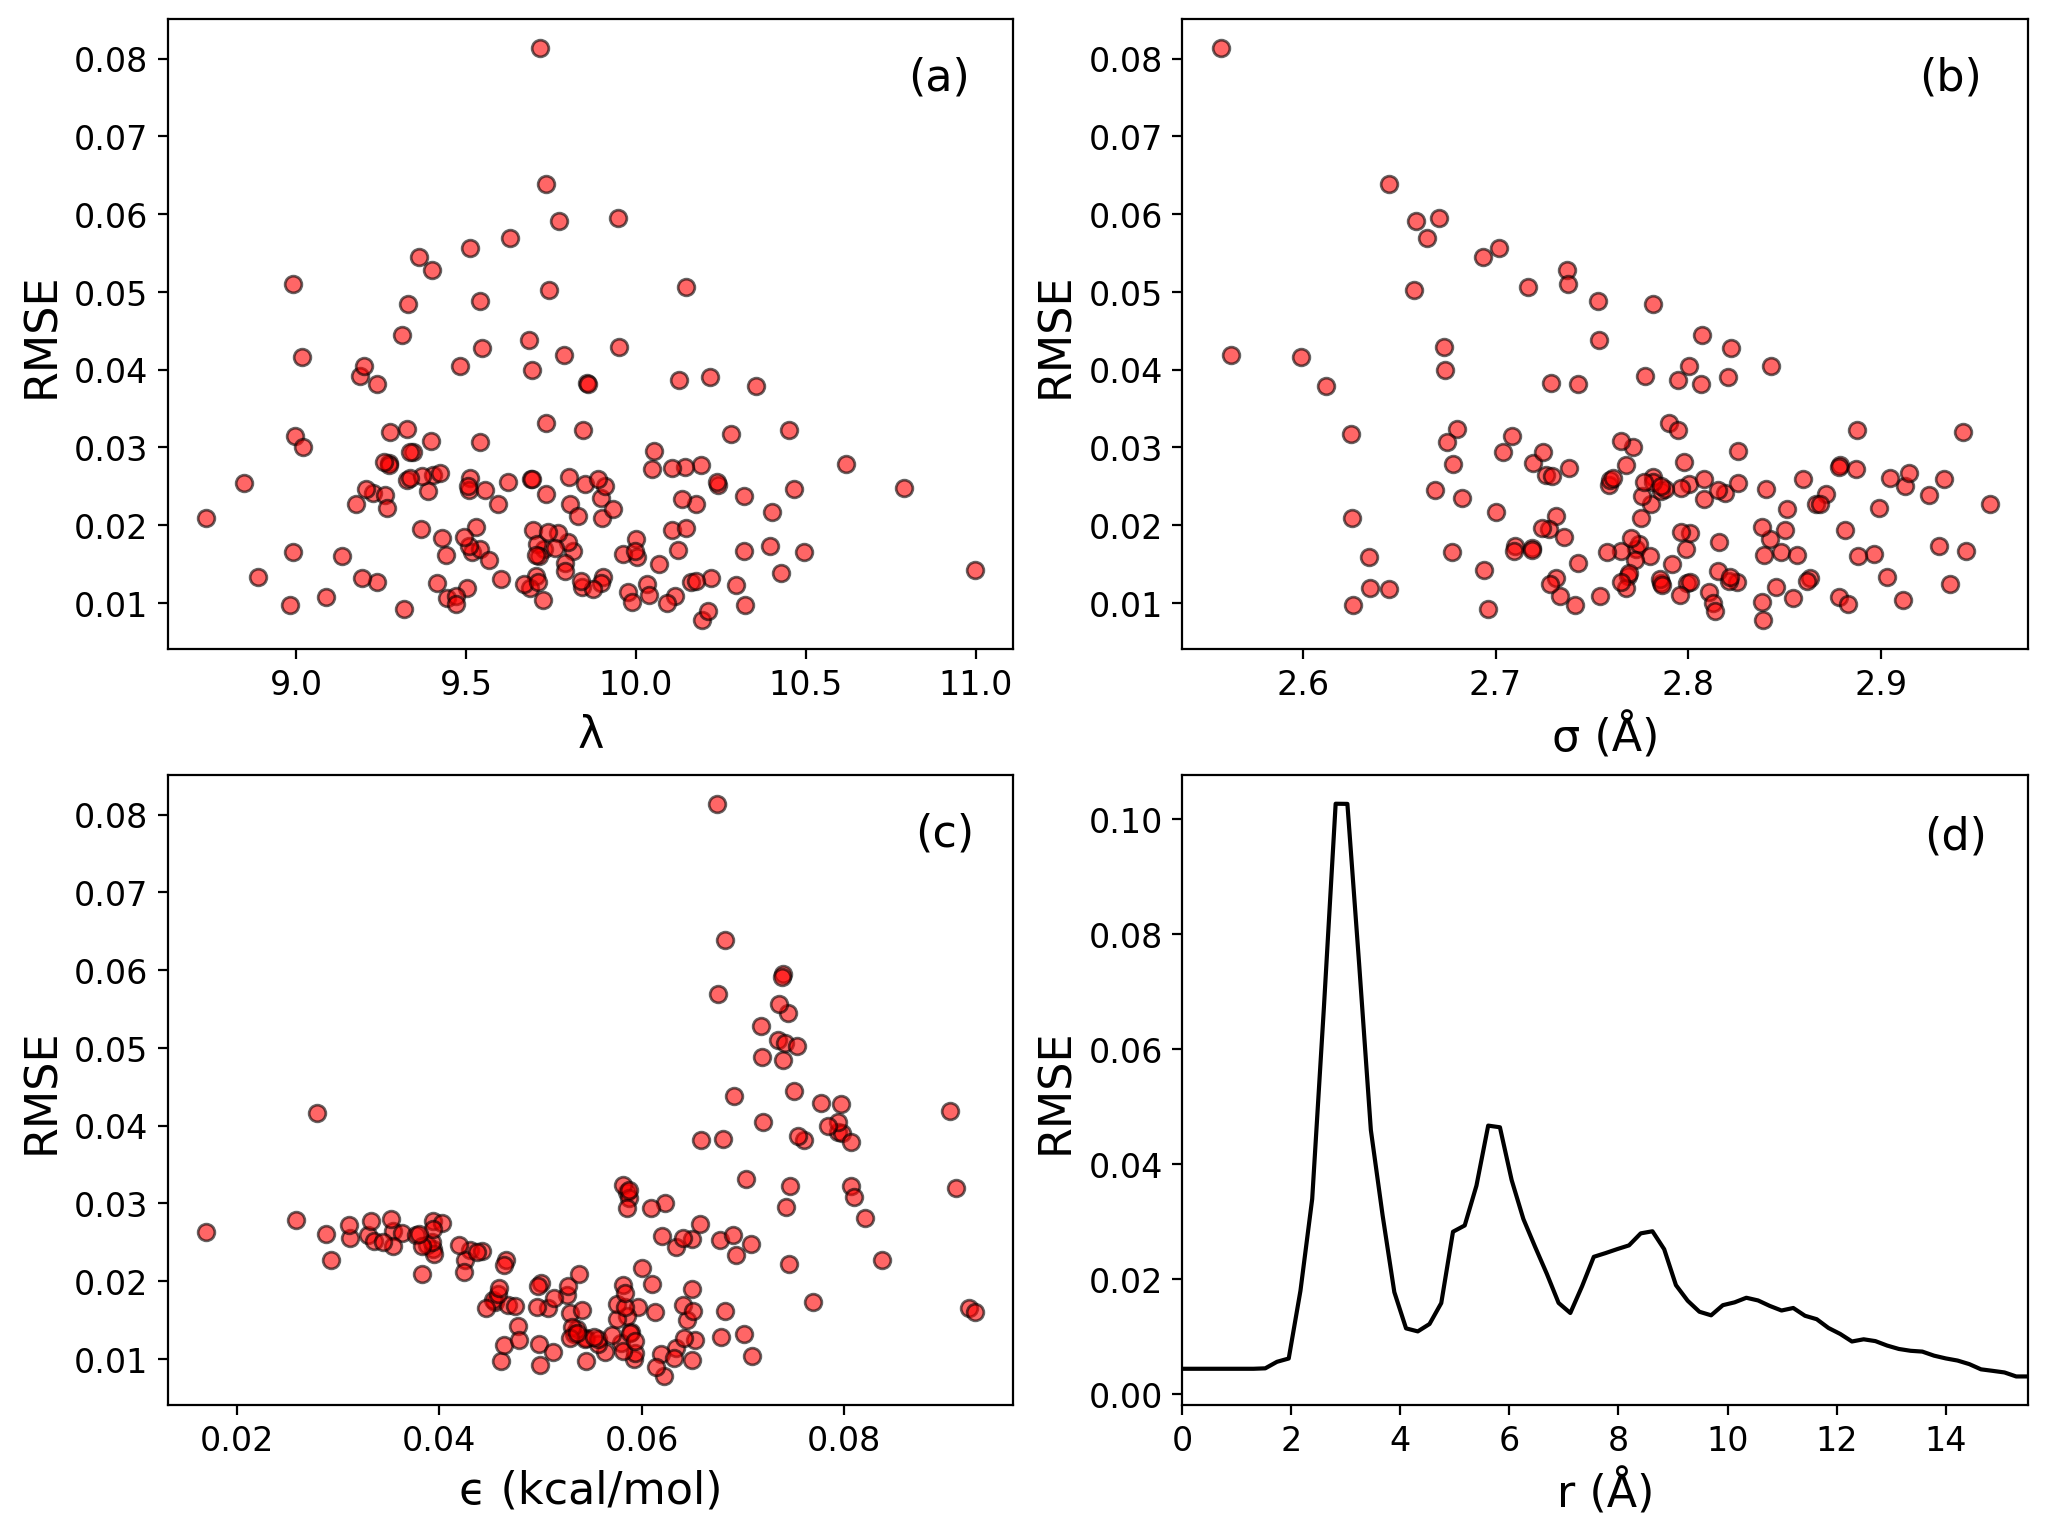

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
axs[0,0].scatter(xs_MAPTest[:,0], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,0].set_xlabel('λ', fontsize = 16)
axs[0,0].set_ylabel('RMSE', fontsize = 16)
axs[0,0].text(10.8, 0.076, '(a)', fontsize = 16)
axs[0,1].scatter(xs_MAPTest[:,1], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[0,1].set_xlabel('σ (Å)', fontsize = 16)
axs[0,1].set_ylabel('RMSE', fontsize = 16)
axs[0,1].text(2.92, 0.076, '(b)', fontsize = 16)
axs[1,0].scatter(xs_MAPTest[:,2], err, color = 'r', alpha = 0.6, edgecolors = 'k')
axs[1,0].set_xlabel('ϵ (kcal/mol)', fontsize = 16)
axs[1,0].set_ylabel('RMSE', fontsize = 16)
axs[1,0].text(0.087, 0.076, '(c)', fontsize = 16)
axs[1,1].plot(r,RMSE, color = 'k', label = 'Mean', linestyle = '-')
axs[1,1].set_xlim(0, r[-1])
axs[1,1].set_xlabel('r (Å)', fontsize = 16)
axs[1,1].set_ylabel('RMSE', fontsize = 16)
axs[1,1].text(13.6, 0.095, '(d)', fontsize = 16)
# plt.savefig('rmse', dpi = 600)
plt.show()

### Worst test set and training set examples (Uncertainity Included from GP)

In [18]:
# GPSorted = GPOut.T[err.argsort()][-30:]
# tensorResultsSorted = tensorResultsRolled[err.argsort()][-30:]
# XiSorted = Xi[err.argsort()][-30:]
# for index in range(len(tensorResultsSorted)):
#     plt.plot(r,tensorResultsSorted[index],label='Sim')
#     plt.plot(r,GPSorted[index],label='GP')
#     plt.title(XiSorted[index])
#     plt.legend()
#     plt.show()
#     print(index)

In [19]:
# GPSorted = GPOut.T[err.argsort()][:]
# tensorResultsSorted = tensorResultsRolled[err.argsort()][:]
# XiSorted = Xi[err.argsort()][:]
# for index in range(len(tensorResultsSorted)):
#     print(index)
#     plt.plot(r,tensorResultsSorted[index],label='Sim')
#     #plt.plot(r,GPSorted[index],label='GP')
#     plt.title(XiSorted[index])
# plt.show()